Get Libraries

In [ ]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import os
import random

from google.colab import files

In [ ]:
work_dir="/content"
os.chdir(work_dir)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# Setup
## gpu setting
gpu = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
uploaded=files.upload()
uploaded=files.upload()
uploaded=files.upload()

Saving test.csv to test.csv


Saving train.csv to train.csv


Saving val.csv to val.csv


Dataset.py

In [ ]:
class MovieLensDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx, :]
        return torch.tensor(row['userId']), torch.tensor(row['movieId']), torch.tensor(row['rating'])


def generate_negative_samples(data, num_items, num_negatives=1):
    """Generate negative samples for each user in the data."""
    data_grouped_by_user = data.groupby('userId').apply(lambda x: x['movieId'].tolist())
    negative_samples = []
    for user_id, positive_items in data_grouped_by_user.items():
        available_items = set(range(num_items)) - set(positive_items)
        negative_items = np.random.choice(list(available_items), size=num_negatives)
        user_ids = [user_id] * num_negatives
        labels = [0] * num_negatives
        negative_samples.extend(zip(user_ids, negative_items, labels))
    negative_samples = pd.DataFrame(negative_samples, columns=['userId', 'movieId', 'rating'])
    data_with_negatives = pd.concat([data, negative_samples])
    return data_with_negatives

def load_data(device=gpu):


    # Load the preprocessed data
    train_data = pd.read_csv(os.path.join(os.getcwd(), 'train.csv'))
    val_data = pd.read_csv(os.path.join(os.getcwd(), 'val.csv'))
    test_data = pd.read_csv(os.path.join(os.getcwd(), 'test.csv'))

    # Combine all data to calculate the number of unique users and items
    all_data = pd.concat([train_data, val_data, test_data])

    # Calculate the number of unique users and items
    num_users = all_data['userId'].nunique()
    num_items = all_data['movieId'].nunique()

    # Generate negative samples for the training and validation data
    train_data = generate_negative_samples(train_data, num_items)
    val_data = generate_negative_samples(val_data, num_items)

    # Convert all positive ratings to 1
    train_data.loc[train_data['rating'] > 0, 'rating'] = 1
    val_data.loc[val_data['rating'] > 0, 'rating'] = 1

    # Create the MovieLensDataset instances
    train_dataset = MovieLensDataset(train_data)
    val_dataset = MovieLensDataset(val_data)

    # Create the data loaders
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    #train_dataloader, val_dataloader, num_users, num_items=train_dataloader.to(device), val_dataloader.to(device), num_users.to(device), num_items.to(device)
    return train_dataloader, val_dataloader, num_users, num_items

util.py

In [ ]:
# From Topology Distillation code base
def sim(A, B, is_inner=False):
	if not is_inner:
		denom_A = 1 / (A ** 2).sum(1, keepdim=True).sqrt()
		denom_B = 1 / (B.T ** 2).sum(0, keepdim=True).sqrt()

		sim_mat = torch.mm(A, B.T) * denom_A * denom_B
	else:
		sim_mat = torch.mm(A, B.T)

	return sim_mat

def calculate_precision_recall(top_indices, labels, top_n):
    relevant_items = set(labels.nonzero().view(-1).cpu().numpy())
    recommended_items = set(top_indices.cpu().numpy())
    intersection = relevant_items & recommended_items
    precision = len(intersection) / len(recommended_items)
    recall = len(intersection) / len(relevant_items) if len(relevant_items) > 0 else 0
    return precision, recall

model.py

In [ ]:
class NCF(nn.Module):
    def __init__(self, num_users, num_items, embed_dim, num_layers, dropout=0.5):
        super(NCF, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embed_dim)
        self.item_embedding = nn.Embedding(num_items, embed_dim)
        self.fc_layers, output_dim = self._create_layers(embed_dim, num_layers, dropout)
        self.output_layer = nn.Linear(output_dim, 1)

    def _create_layers(self, embed_dim, num_layers, dropout):
        fc_layers = []
        input_dim = 2 * embed_dim  # Adjust the input size
        for i in range(num_layers - 1):
            output_dim = input_dim // 2
            fc_layers.append(nn.Linear(input_dim, output_dim))
            fc_layers.append(nn.ReLU())
            fc_layers.append(nn.Dropout(dropout))
            input_dim = output_dim  # Update the input size for the next layer
        return nn.Sequential(*fc_layers), output_dim

    def forward(self, user_indices, item_indices):
        user_indices = user_indices.long()
        item_indices = item_indices.long()
        user_embedding = self.user_embedding(user_indices)
        item_embedding = self.item_embedding(item_indices)
        x = torch.cat([user_embedding, item_embedding], dim=-1)
        x = self.fc_layers(x)
        x = self.output_layer(x)
        return x

class FTD(NCF):
    def __init__(self, user_num, item_num, embed_dim, num_layers, dropout=0.5, device=gpu):
        super().__init__(user_num, item_num, embed_dim, num_layers, dropout)

        self.student_dim = embed_dim

        # Teacher
        self.user_emb_teacher = nn.Embedding(user_num, embed_dim).to(device)
        self.item_emb_teacher = nn.Embedding(item_num, embed_dim).to(device)

        self.teacher_dim = self.user_emb_teacher.weight.size(1)

        # Move the embeddings to the device
        self.user_embedding = self.user_embedding.to(device)
        self.item_embedding = self.item_embedding.to(device)

    # topology distillation loss
    def get_TD_loss(self, batch_user, batch_item):
        device = self.user_emb_teacher.weight.device
        batch_user = batch_user.long().to(device)
        batch_item = batch_item.long().to(device)
        s = torch.cat([self.user_embedding(batch_user), self.item_embedding(batch_item)], 0).to(device)
        t = torch.cat([self.user_emb_teacher(batch_user), self.item_emb_teacher(batch_item)], 0).to(device)

        s = s / torch.norm(s, dim=1, keepdim=True)
        t = t / torch.norm(t, dim=1, keepdim=True)

        # Full topology
        t_dist = sim(t, t).view(-1)
        s_dist = sim(s, s).view(-1)

        # print(f't_dist: {t_dist}, s_dist: {s_dist}')
        total_loss = ((t_dist - s_dist) ** 2).sum()

        return total_loss

    def forward(self, user_indices, item_indices):
        device = self.user_emb_teacher.weight.device
        user_indices = user_indices.long().to(device)
        item_indices = item_indices.long().to(device)
        user_embedding = self.user_embedding(user_indices).to(device)
        item_embedding = self.item_embedding(item_indices).to(device)
        x = torch.cat([user_embedding, item_embedding], dim=-1)
        x = self.fc_layers(x)
        x = self.output_layer(x)
        return x

train_ncf

In [ ]:
def train_ncf_epoch(model, dataloader, optimizer, criterion, device=gpu):
    print('Training the model...')

    model.train()
    total_loss = 0
    # i = 0
    for user_indices, item_indices, labels in dataloader:
        # i += 1
        # print(i)
        user_indices = user_indices.to(device)
        item_indices = item_indices.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(user_indices, item_indices)
        outputs = outputs.view(-1)

        # Ensure labels is a 1D tensor with the same shape as outputs
        labels = labels.view(-1)
        # print(f'Labels min: {labels.min()}, max: {labels.max()}')
        # print(f'Outputs min: {outputs.min()}, max: {outputs.max()}')
        # Calculate the loss
        loss = criterion(outputs, labels)
        # print(f'Loss: {loss.item()}')
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)

def validate_ncf_epoch(model, dataloader, top_n, device=gpu):
    model.eval()
    precisions = []
    recalls = []
    with torch.no_grad():
        for user_indices, item_indices, labels in dataloader:
            user_indices = user_indices.to(device)
            item_indices = item_indices.to(device)
            labels = labels.to(device)

            # Forward pass

            outputs = model(user_indices, item_indices)
            outputs = outputs.view(-1)
            # print(f'Size of outputs: {outputs.numel()}, top_n: {top_n}')
            # Calculate the top-N recommendations
            top_n = min(top_n, outputs.numel())
            _, top_indices = torch.topk(outputs, top_n)

            # Calculate the precision and recall
            precision, recall = calculate_precision_recall(top_indices, labels, top_n)
            precisions.append(precision)
            recalls.append(recall)

            # print(f'Precision: {precision}, Recall: {recall}')

    return np.mean(precisions), np.mean(recalls)

def train_ncf(train_dataloader, val_dataloader, num_users, num_items,model_name, device=gpu,num_layers=2):
    # Define the hyperparameters
    embed_dim = 200
    num_epochs = 50
    top_n = 10
    pre=[]
    rec=[]
    # Instantiate the model, the criterion, and the optimizer
    model = NCF(num_users, num_items, embed_dim, num_layers)
    model = model.to(device)
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters())


    # Train and validate the model
    for epoch in range(num_epochs):
        train_loss = train_ncf_epoch(model, train_dataloader, optimizer, criterion, device)
        precision, recall = validate_ncf_epoch(model, val_dataloader, top_n, device)
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Precision@{top_n}: {precision:.4f}')
        print(f'Recall@{top_n}: {recall:.4f}')


        pre.append(precision)
        rec.append(recall)


    # Save the model
    torch.save(model.state_dict(), model_name+'.pth')

    return pre,rec


# **Change Params**

In [ ]:
# layers can vary from 2 to 7
#num_embed=200. >2^layers

In [ ]:
train_dataloader, val_dataloader, num_users, num_items = load_data()
layers=7
m_name=f'model_ncf_{layers}'

pre,rec=train_ncf(train_dataloader, val_dataloader, num_users, num_items,model_name=m_name, num_layers=layers)
model_path=os.path.join(os.getcwd(), f'{m_name}.pth')

Training the model...
Epoch 1/50
Train Loss: 0.2568
Precision@10: 0.9455
Recall@10: 0.1484
Training the model...
Epoch 2/50
Train Loss: 0.1259
Precision@10: 0.9449
Recall@10: 0.1482
Training the model...
Epoch 3/50
Train Loss: 0.0789
Precision@10: 0.9455
Recall@10: 0.1484
Training the model...
Epoch 4/50
Train Loss: 0.0568
Precision@10: 0.9461
Recall@10: 0.1486
Training the model...
Epoch 5/50
Train Loss: 0.0460
Precision@10: 0.9455
Recall@10: 0.1484
Training the model...
Epoch 6/50
Train Loss: 0.0382
Precision@10: 0.9455
Recall@10: 0.1484
Training the model...
Epoch 7/50
Train Loss: 0.0327
Precision@10: 0.9455
Recall@10: 0.1484
Training the model...
Epoch 8/50
Train Loss: 0.0309
Precision@10: 0.9455
Recall@10: 0.1484
Training the model...
Epoch 9/50
Train Loss: 0.0291
Precision@10: 0.9455
Recall@10: 0.1484
Training the model...
Epoch 10/50
Train Loss: 0.0285
Precision@10: 0.9455
Recall@10: 0.1484
Training the model...
Epoch 11/50
Train Loss: 0.0267
Precision@10: 0.9455
Recall@10: 0.14

In [ ]:
import matplotlib.pyplot as plt

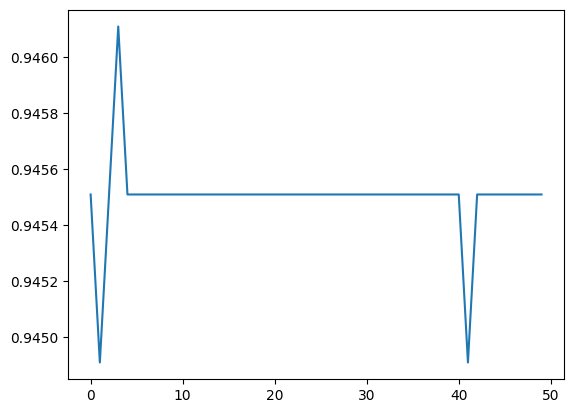

In [ ]:
plt.plot(pre)


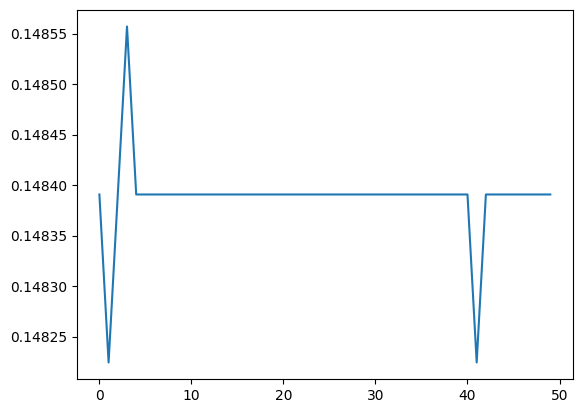

In [ ]:
plt.plot(rec)

train_ftd

In [ ]:
def ftd_train_epoch(model, train_loader, criterion, optimizer, device, lmbda_TD):
    model.train()
    total_loss = 0.0

    for i, (user, item, label) in enumerate(train_loader):
        user = user.to(device)
        item = item.to(device)
        label = label.to(device)

        # Forward pass
        output = model(user, item)
        output = output.view(-1)

        # Compute L_base
        base_loss = criterion(output, label)

        # Topology Distillation
        # Compute L_FTD
        TD_loss = model.get_TD_loss(user.unique(), item.unique())

        # Compute L = L_base + lambda * L_FTD
        loss = base_loss + TD_loss * lmbda_TD

        # Update Student model by minimizing L
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss

def evaluate_ftd_epoch(model, test_loader, criterion, device, lmbda_TD, top_n):
    model.eval()
    total_loss = 0.0
    precisions = []
    recalls = []

    with torch.no_grad():
        for i, (user, item, label) in enumerate(test_loader):
            user = user.to(device)
            item = item.to(device)
            label = label.to(device)

            # Forward pass
            output = model(user, item)
            output = output.view(-1)

            # Compute L_base
            base_loss = criterion(output, label)

            # Topology Distillation
            # Compute L_FTD
            TD_loss = model.get_TD_loss(user.unique(), item.unique())

            # Compute L = L_base + lambda * L_FTD
            loss = base_loss + TD_loss * lmbda_TD
            # print(TD_loss)
            total_loss += loss.item()

            # Calculate the top-N recommendations
            top_n = min(top_n, output.numel())
            _, top_indices = torch.topk(output, top_n)

            # Calculate the precision and recall
            precision, recall = calculate_precision_recall(top_indices, label, top_n)
            precisions.append(precision)
            recalls.append(recall)

    # Calculate the accuracy
    accuracy = np.mean(precisions)

    return total_loss, accuracy, np.mean(precisions), np.mean(recalls)

def ftd_train(train_dataloader, val_dataloader,user_emb_teacher, item_emb_teacher, num_users, num_items, device, model_name, num_layers=2):
    # Define the hyperparameters
    embed_dim = 50
    num_epochs = 50
    top_n = 10
    lmbda_TD = 0.5
    pre=[]
    rec=[]
    # Instantiate the mode
    model = FTD(num_users, num_items, embed_dim, num_layers, device=device)
    model = model.to(device)

    # Load the pretrained embeddings
    model.user_emb_teacher.weight.data = user_emb_teacher
    model.item_emb_teacher.weight.data = item_emb_teacher

    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters())

    # Train and validate the model
    for epoch in range(num_epochs):
        train_loss = ftd_train_epoch(model, train_dataloader, criterion, optimizer, device, lmbda_TD)
        test_loss, accuracy, precision, recall = evaluate_ftd_epoch(model, val_dataloader, criterion, device, lmbda_TD, top_n)
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')
        print(f'Precision@{top_n}: {precision:.4f}')
        print(f'Recall@{top_n}: {recall:.4f}')
        pre.append(precision)
        rec.append(recall)

    # Save the model

    torch.save(model.state_dict(), model_name+'.pth')
    return pre,rec

In [ ]:
 # Load the data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load the data
train_dataloader, val_dataloader, num_users, num_items = load_data()

    # Load the pretrained model
pretrained_model = NCF(num_users, num_items, 200, 7)
pretrained_model.load_state_dict(torch.load('/content/model_ncf_7.pth'))
pretrained_model = pretrained_model.to(device)

    # Get the user and item embeddings
user_emb_teacher = pretrained_model.user_embedding.weight.data.to(device)
item_emb_teacher = pretrained_model.item_embedding.weight.data.to(device)


    # Train FTD
pre,rec=ftd_train(train_dataloader, val_dataloader, user_emb_teacher, item_emb_teacher, num_users, num_items, device, model_name='model_ftd', num_layers=2)

Epoch 1/50
Train Loss: 766641.7471
Test Loss: 77986.5799, Accuracy: 0.9449
Precision@10: 0.9449
Recall@10: 0.1482
Epoch 2/50
Train Loss: 512349.1639
Test Loss: 48790.6325, Accuracy: 0.9455
Precision@10: 0.9455
Recall@10: 0.1484
Epoch 3/50
Train Loss: 296633.2764
Test Loss: 28582.8125, Accuracy: 0.9461
Precision@10: 0.9461
Recall@10: 0.1486
Epoch 4/50
Train Loss: 177356.1482
Test Loss: 19622.8069, Accuracy: 0.9461
Precision@10: 0.9461
Recall@10: 0.1486
Epoch 5/50
Train Loss: 125762.6745
Test Loss: 15236.6290, Accuracy: 0.9461
Precision@10: 0.9461
Recall@10: 0.1486
Epoch 6/50
Train Loss: 96847.3933
Test Loss: 12343.1794, Accuracy: 0.9461
Precision@10: 0.9461
Recall@10: 0.1486
Epoch 7/50
Train Loss: 76488.8390
Test Loss: 10174.6308, Accuracy: 0.9461
Precision@10: 0.9461
Recall@10: 0.1486
Epoch 8/50
Train Loss: 60965.0856
Test Loss: 8490.7649, Accuracy: 0.9461
Precision@10: 0.9461
Recall@10: 0.1486
Epoch 9/50
Train Loss: 49050.4079
Test Loss: 7170.3735, Accuracy: 0.9461
Precision@10: 0.946

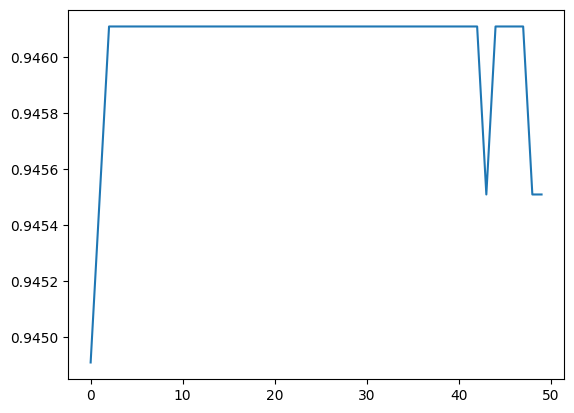

In [ ]:
plt.plot(pre)

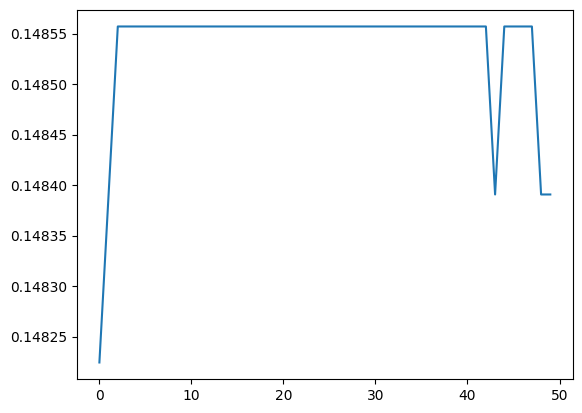

In [ ]:
plt.plot(rec)

In [ ]:
uploaded=files.upload()

Saving ftd_train.txt to ftd_train.txt


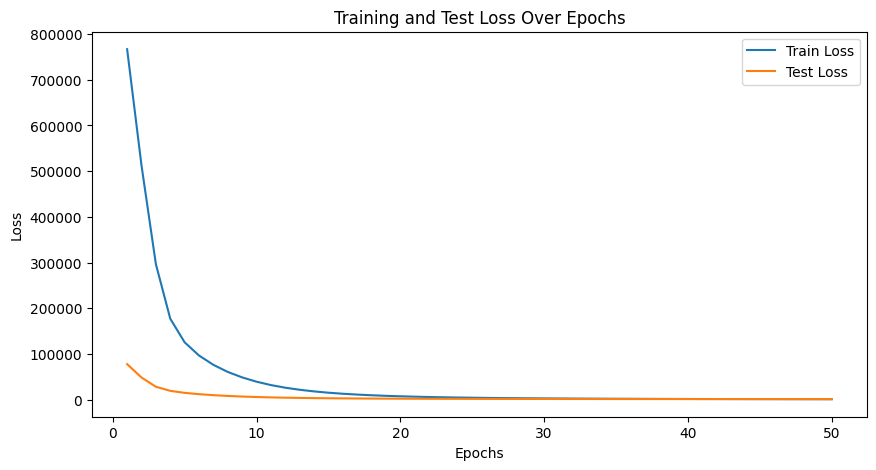

In [ ]:
with open('ftd_train.txt', 'r') as file:
    lines = file.readlines()

# Extract training and test loss from each epoch
train_loss = [float(line.split('Train Loss: ')[1].split('\n')[0]) for line in lines if 'Train Loss:' in line]
test_loss = [float(line.split('Test Loss: ')[1].split(',')[0]) for line in lines if 'Test Loss:' in line]

# Create a list of epochs
epochs = list(range(1, len(train_loss) + 1))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, test_loss, label='Test Loss')
plt.title('Training and Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()